ASTR241 Exoplanets Homework Code, Spring 2023
Process and fit transiting exoplanet data by minimizing a log likelihood function and investigating with a MCMC

1) Normalize flux calibrations so that out-of-transit = 1.
2) Assume perfect trapezoid profile.
3) Look at the period of the planet and an average transit time. Measure the transit times for each event and fit them with equation 32. *t_c[n] = t_c[0] + nP*
4) Directly measure transit depth, transit duration, and the ingress/egress time.
5) Consider overlaying the data from the different transits (after normalization and removing systematics) to get higher precision on transit parameters.
6) Part of this exercise is to figure out (and justify) which parameters are possible to determine, and which parameters are important to determine!
7) Estimate the gain of the instrument that was used.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import emcee
from scipy.optimize import minimize
from time import time 

In [2]:
def plot_pretty():
    plt.rcParams['figure.dpi']= 300
    plt.rc('savefig', dpi=300)
    plt.rc('font', size=20)
    plt.rc('axes',labelsize=18,titlesize=18)
    plt.rc('xtick', direction='out',labelsize=1) 
    plt.rc('ytick', direction='out',labelsize=16)
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    plt.rc('figure', titlesize=20)
    plt.tick_params(which='major',length=6, width=1.5,labelsize=18)
    plt.minorticks_on()
    plt.tick_params(which='minor',length=3,width=1)

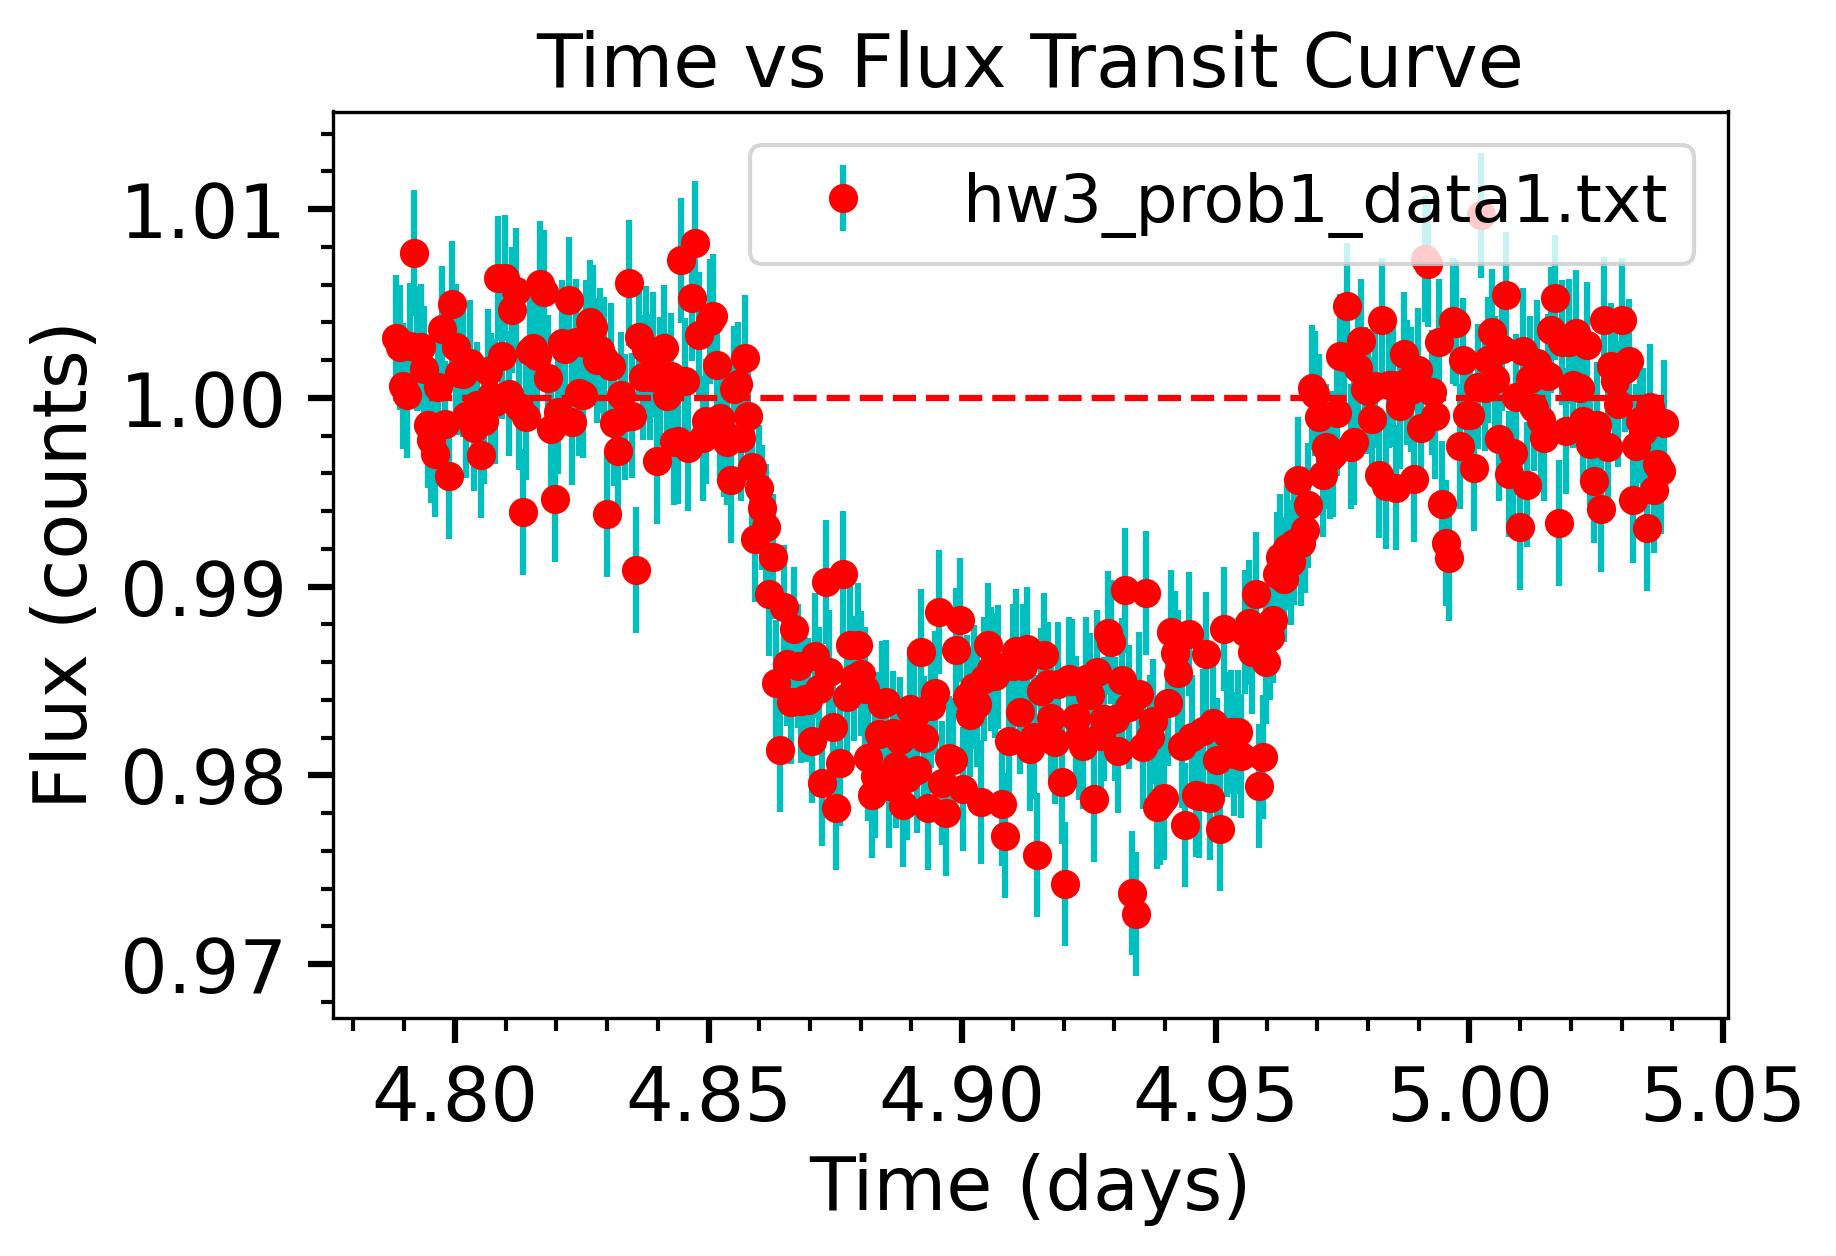

In [19]:
def get_data(file):
    f = open(file,'r')

    time, flux, unc = np.empty((364)), np.empty((364)), np.empty((364))

    for i,line in enumerate(f):
        # ignore first 3 lines
        if i in [0,1,2]:
            continue
        # strip and split extra chars
        line = line.strip()
        line = line.split('\n')
        arr = line[0].split('     ')
        arr = np.asarray(arr)
        arr = arr.astype(float)
        time[i], flux[i], unc[i] = arr[0], arr[1], arr[2]

    time, flux, unc = time[3:], flux[3:], unc[3:]
    return time, flux, unc

def normalize_flux(flux,uncertainty):
    enter,exit = np.mean(flux[:30]), np.mean(flux[-29:])
    mean_val = (enter + exit) / 2
    flux_norm = ((flux - mean_val) / mean_val) + 1
    unc_norm = uncertainty / mean_val
    
    return flux_norm,unc_norm

def transit_plot(file):        
    fig, ax = plt.subplots()
    plot_pretty()
    if type(file) == str:
        time, flux, unc = get_data(file)
        flux_norm, unc_norm = normalize_flux(flux,unc)
        ax.errorbar(time,flux_norm,yerr=unc_norm,fmt='o',c='r',ecolor='c',label=file)
        ax.plot(time,[1]*len(time),'--',c='r')
    if type(file) == list:
        for name in file:
            time, flux, unc = get_data(name)
            flux_norm, unc_norm = normalize_flux(flux,unc)
            ax.errorbar(time,flux_norm,yerr=unc_norm,fmt='o',c='r',ecolor='c',label=name)
            ax.plot(time,[0]*len(time),'--',c='r')

    ax.set_title('Time vs Flux Transit Curve')
    ax.set_xlabel('Time (days)',fontsize=18), ax.set_ylabel('Flux (counts)',fontsize=18)
    plt.legend(fontsize=16)
    plt.show()

sets = ['hw3_prob1_data1.txt','hw3_prob1_data2.txt','hw3_prob1_data3.txt']
transit_plot(sets[0])

In [5]:
def trapmodel(time, delta, tau, T, t0):
    t1 = t0 - (T + tau)/2
    t2 = t0 - (T - tau)/2
    t3 = t0 + (T - tau)/2
    t4 = t0 + (T + tau)/2
    
    out = np.ones_like(time)
    
    ingress = np.where((t1 <= time) & (time <= t2))
    out[ingress] = 1-(delta/(t2-t1))*(time[ingress] - t1)
    
    egress = np.where((t3 <= time) & (time <= t4))
    out[egress] = 1-(delta/(t4-t3))*(t4 - time[egress])
    
    transit = np.where((t2 <= time) & (time <= t3))
    out[transit] = 1-delta
    
    return(out)

def lnlike(params, time, flux, std):
    delta, tau, T, t0 = params
    model = trapmodel(time-np.min(time), delta, tau, T, t0)
    
    return( -0.5*np.sum((model-flux)**2 / std**2) )

In [7]:
ti,f_a,u_a = get_data(sets[2])
f, u = normalize_flux(f_a,u_a)

# minimize log likelihood function
nll = lambda *args: -lnlike(*args)
# initial guess values of params
# guess 1: initial = [0.02,0.03,0.10,0.15]
initial = [0.02,0.02,0.09,0.10]
soln = minimize(nll, initial, args=(ti, f, u))

print(soln.x)

pos = initial + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnlike, args=(ti, f, u)
)

t0 = time() # start time
sampler.run_mcmc(pos, 5000, progress=True)

t1 = time()

timeemcee = (t1-t0)
print("Time taken to run 'emcee' is {} seconds".format(timeemcee))


[0.01768218 0.01291584 0.1029495  0.09518888]


100%|██████████| 5000/5000 [00:15<00:00, 324.11it/s]

Time taken to run 'emcee' is 15.445688009262085 seconds


Text(0.5, 0, 'step number')

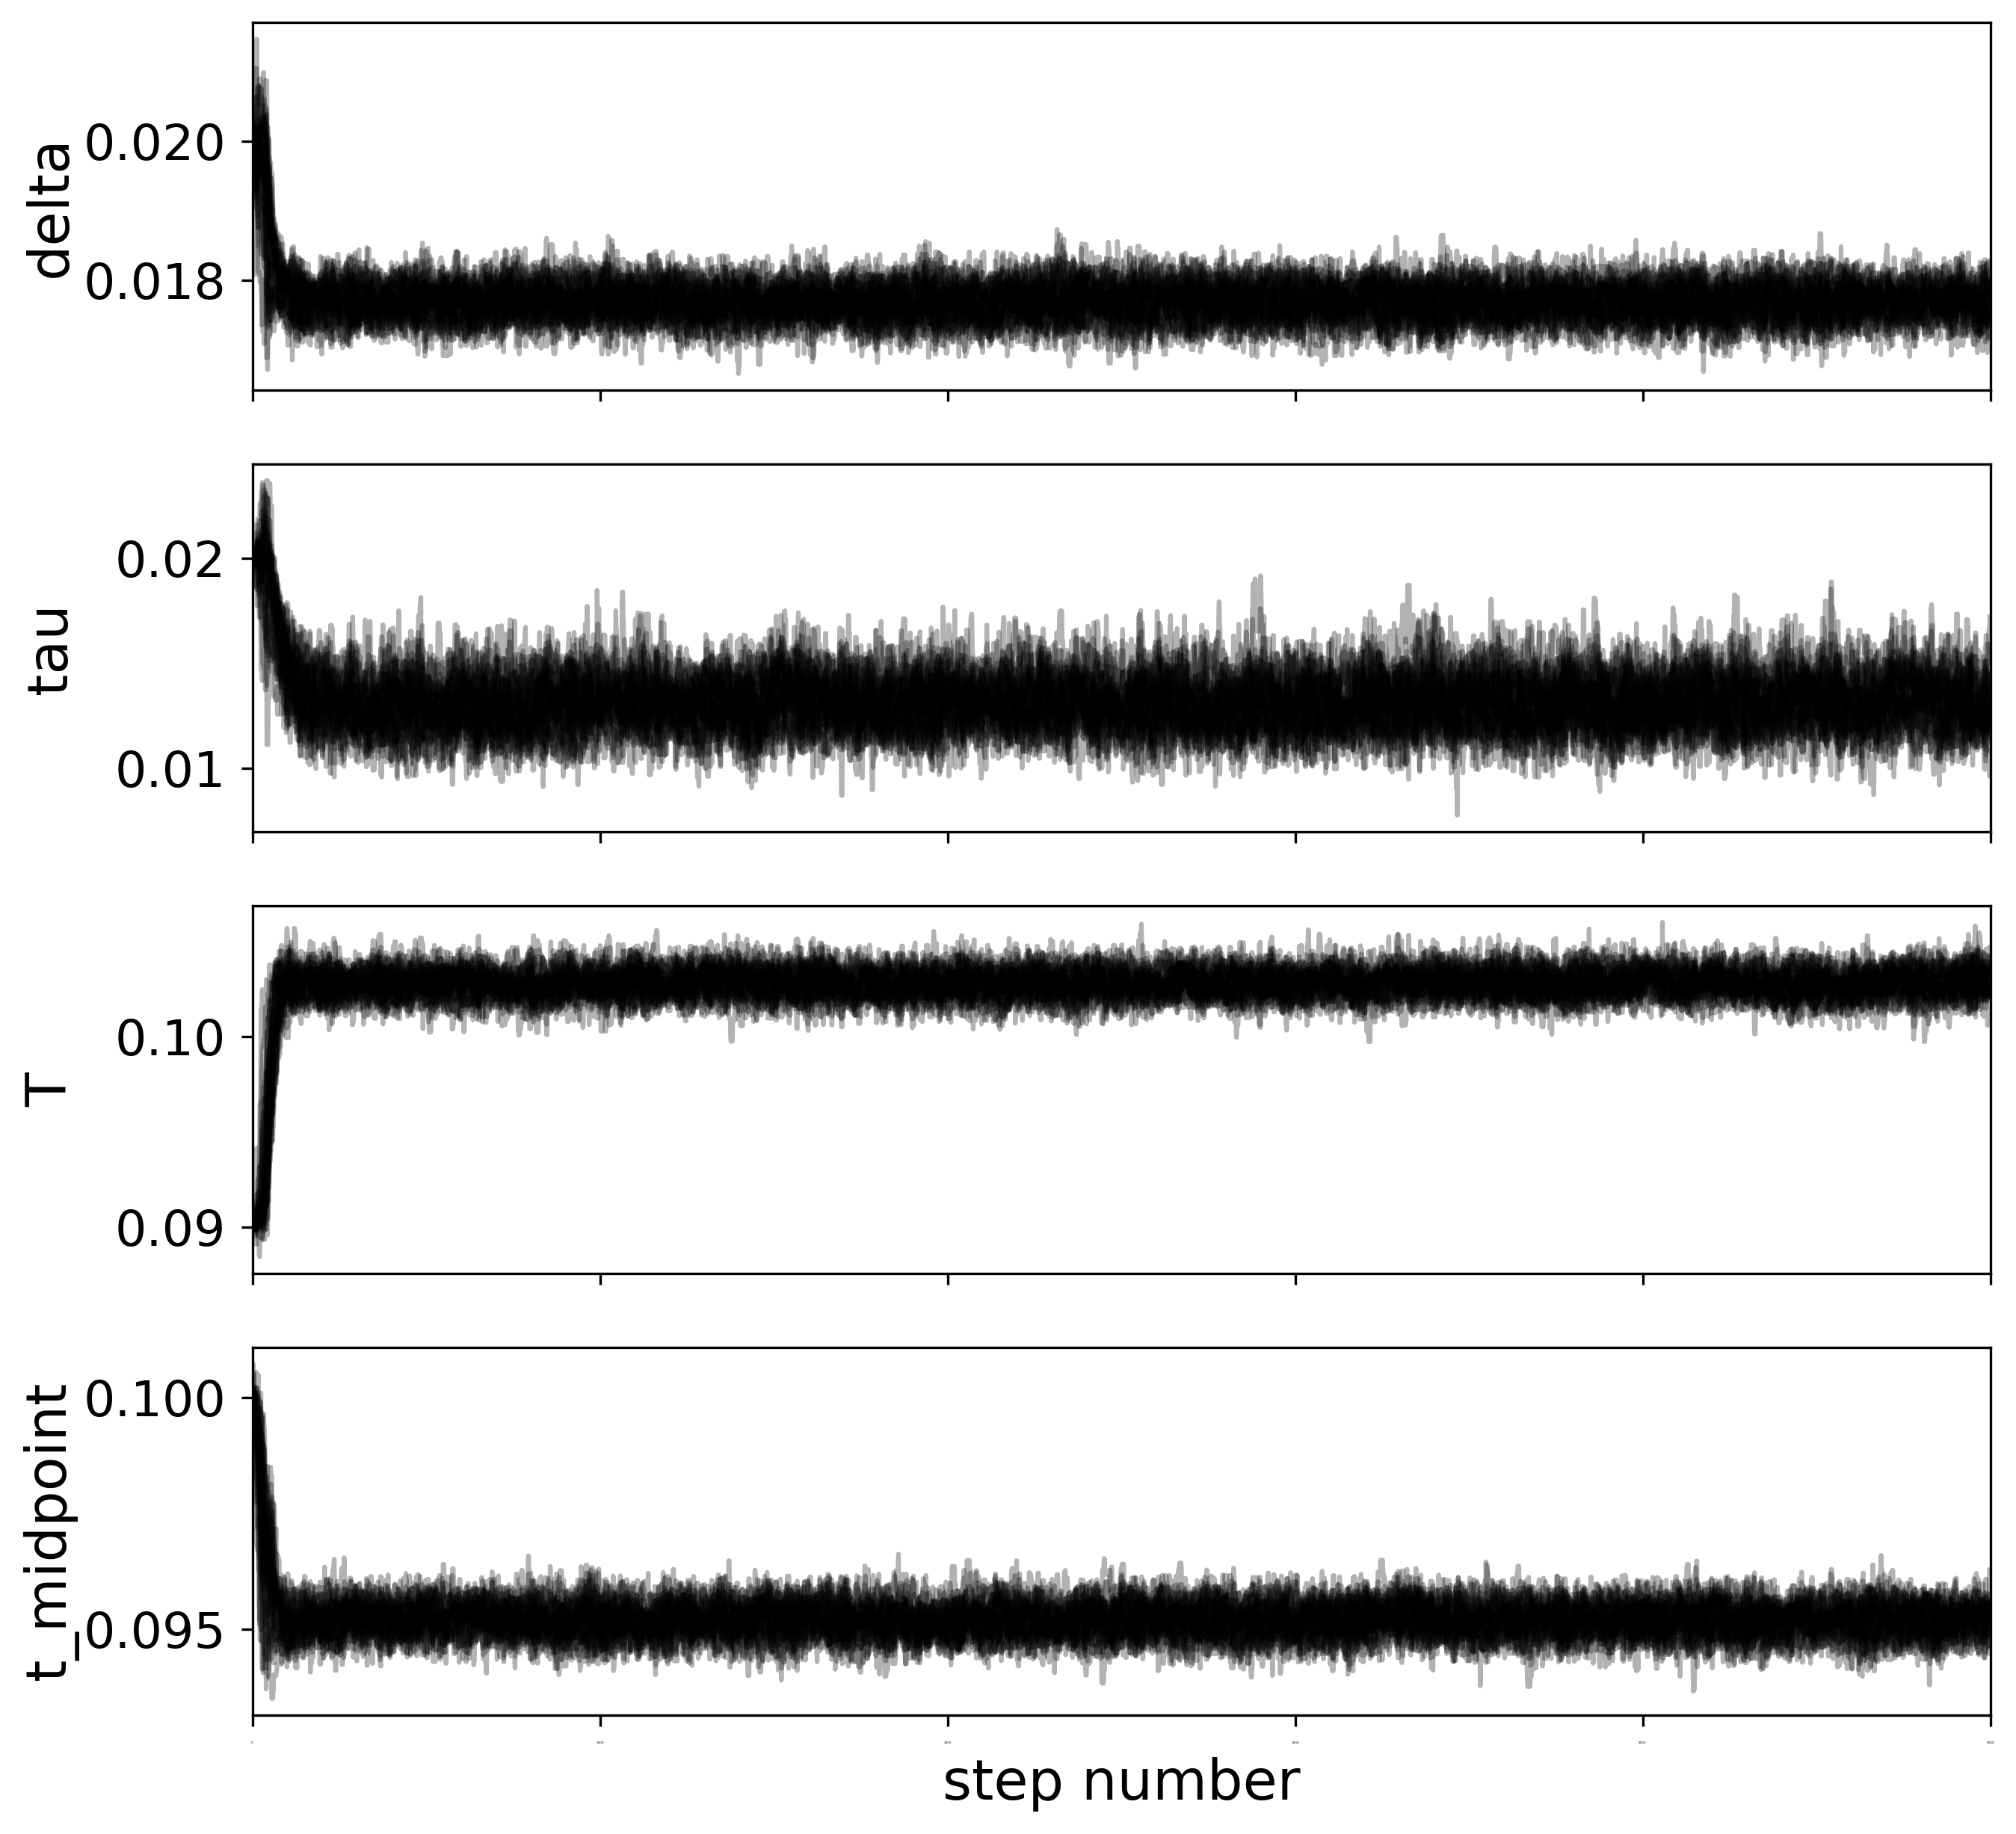

In [8]:
fig, axes = plt.subplots(4, figsize=(10, 10), sharex=True)
samples = sampler.get_chain()
labels = ["delta", "tau", "T","t_midpoint"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [9]:
taf = sampler.get_autocorr_time()
print(taf)

[50.98769042 60.2257342  56.84880236 43.99369485]


In [10]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 4)


In [11]:
params_1, params_2, params_3 = [], [], []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    print(txt)
    params_1.append([mcmc[1],q[0],q[1],labels[i]])


\mathrm{delta} = 0.018_{-0.000}^{0.000}
\mathrm{tau} = 0.013_{-0.001}^{0.001}
\mathrm{T} = 0.103_{-0.001}^{0.001}
\mathrm{t_midpoint} = 0.095_{-0.000}^{0.000}


9.183754509725985


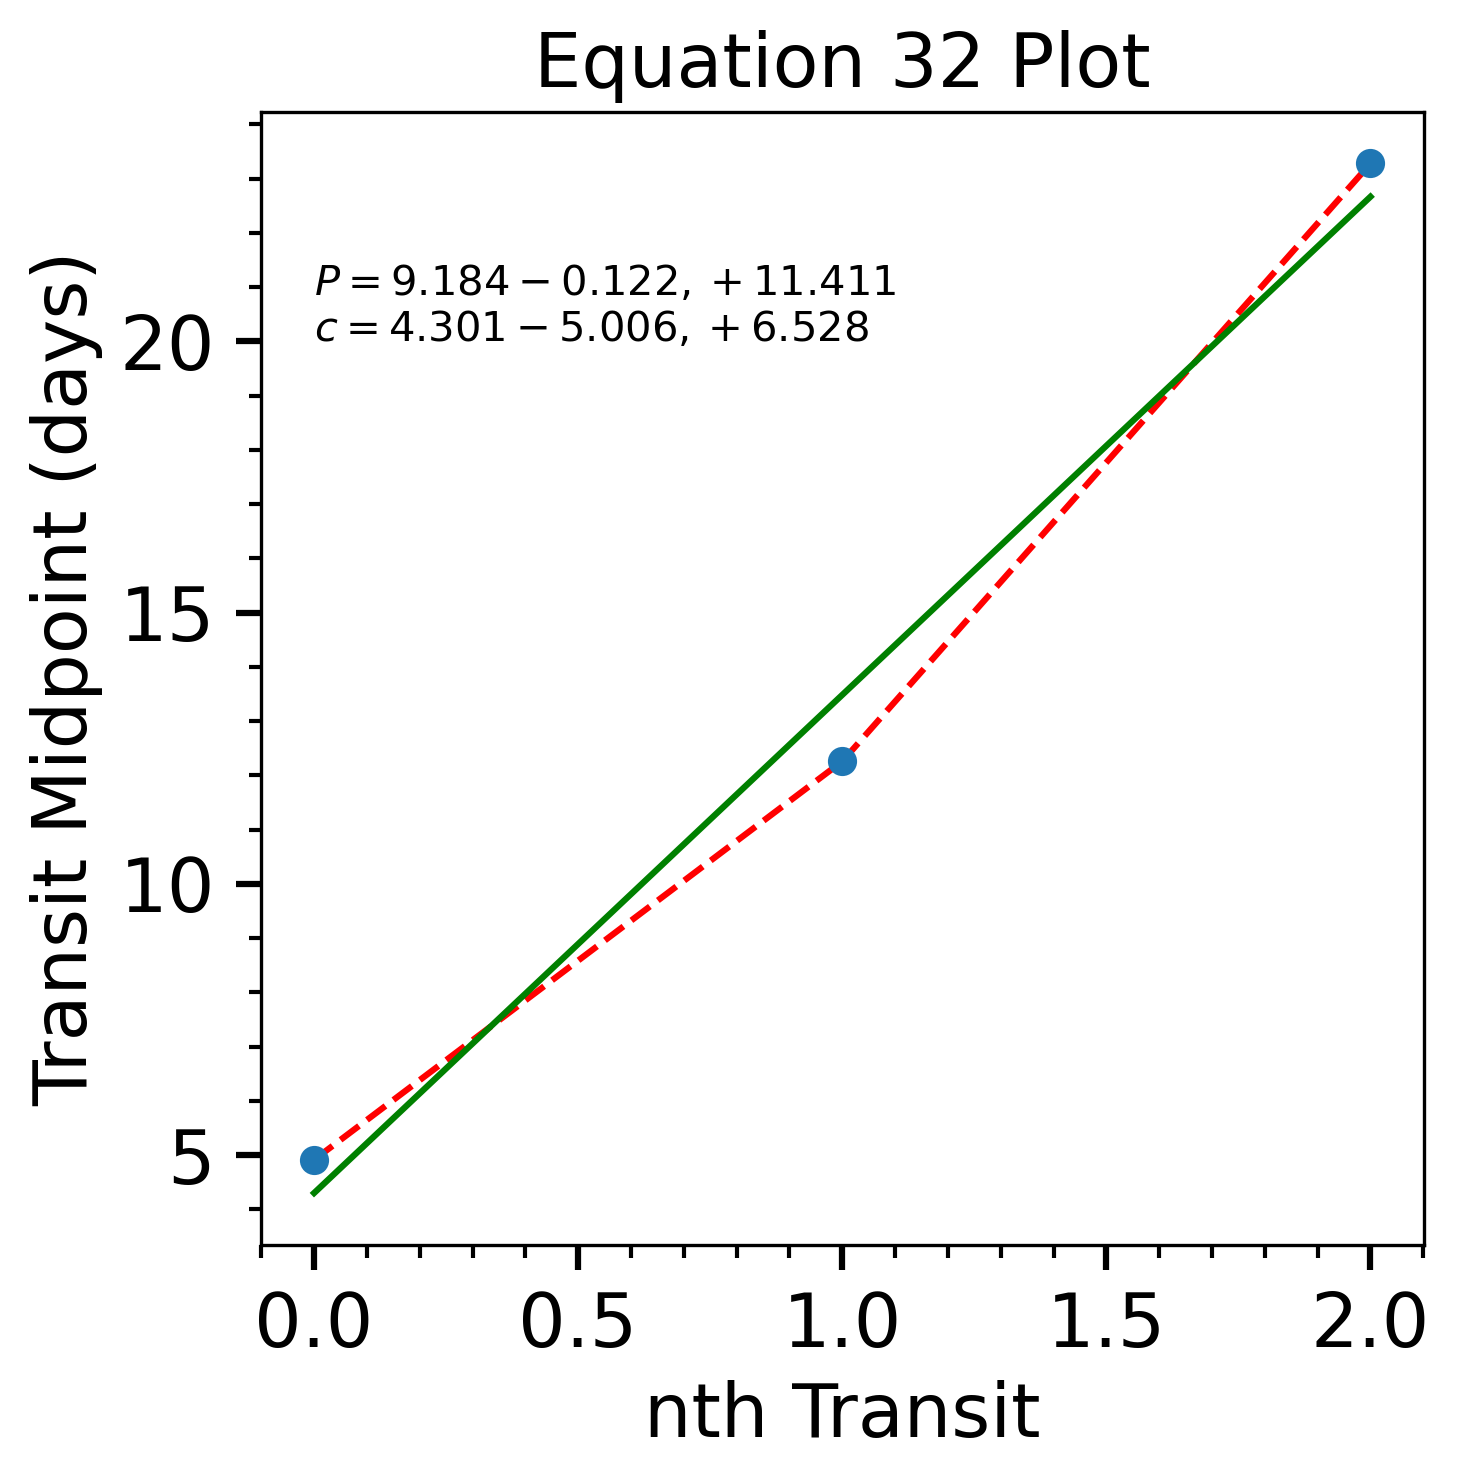

In [12]:
params_1 = [[0.017081019031650598, 0.00030496347752784897, 0.00030099484411700433, 'delta'], 
            [0.013469002562835362, 0.00232873982716013, 0.0033176348507221037, 'tau'], 
            [0.1025499978299241, 0.0010300489177568761, 0.0009754505886041542, 'T'], 
            [0.12463186953660568, 0.00047051624256391755, 0.0004763590335409851, 't_midpoint']]

params_2 = [[0.018457927912943442, 0.0003435522042417073, 0.0003553864559572087, 'delta'], 
            [0.01384304234621073, 0.0025949089730229625, 0.0031828127682237174, 'tau'], 
            [0.10199064219889137, 0.0010612971630432344, 0.0010737823768366545, 'T'], 
            [0.17433999845951562, 0.0005688092781871712, 0.0005147540264122119, 't_midpoint']]

params_3 = [[0.017696574724747435, 0.00024373814900487123, 0.00024215093040958965, 'delta'], 
            [0.01302914503933714, 0.0010860955750411974, 0.0012084038782733397, 'tau'], 
            [0.10283472723346622, 0.0007015796666024338, 0.0006835696831132138, 'T'], 
            [0.09517256898857088, 0.0003300365340783151, 0.00034123351929424284, 't_midpoint']]

# t_c[n] = t_c[0] + nP, (t_c[n] - t_c[0]) / n = P
t_min = [4.78839367,12.085181,23.18536199]

midpoints = [params_1[3][0]+t_min[0],params_2[3][0]+t_min[1],params_3[3][0]+t_min[2]]
mid_errors = np.asarray([[params_1[3][1],params_2[3][1],params_3[3][1]],[params_1[3][2],params_2[3][2],params_3[3][2]]])

P_fit = np.polyfit([0,1,2],midpoints,deg=1)
eq = P_fit[0]*np.asarray([0,1,2]) + P_fit[1]
P_day,c = P_fit[0], P_fit[1]
# contains lower/upper err propagations for P, constant
P_err_day  = [(1/0.10745547,1/-0.44901732,1/0.10745348, 1/-0.44889368),(P_day,P_day,c,c)]
P_err_day = np.diff(P_err_day,axis=0)[0]
print(P_day)

fig,ax = plt.subplots(figsize=(5,5))
plot_pretty()

ax.errorbar([0,1,2],midpoints,xerr=mid_errors,fmt='o',ecolor='r')
ax.plot([0,1,2],midpoints,'r--')
ax.plot([0,1,2],eq,'g')

txt = r'$P = {:.3f}_-{:.3f}^+{:.3f}$'+'\n'+r'$c = {:.3f}_-{:.3f}^+{:.3f}$'
plt.text(0,20,txt.format(P_day,P_err_day[0],P_err_day[1],c,P_err_day[2],P_err_day[3]),fontsize=10)

ax.set_xlabel('nth Transit'), ax.set_ylabel('Transit Midpoint (days)')
ax.set_title('Equation 32 Plot')
plt.show()

In [18]:
#M_p, R_p, R_star, stellar density, a, b
K = 141.24
e = 0.0 
solar_mass = 1.989e30
solar_radius = 6.957e8
M_star = 0.9 * solar_mass
M_J = 1.898e27
G = 6.67e-11
AU = 1.496e+11
sec = 86400

# convert days to seconds
delta = np.mean([params_1[0][0],params_2[0][0],params_3[0][0]])
delta_u = np.asarray([np.mean([params_1[0][1],params_2[0][1],params_3[0][1]]),np.mean([params_1[0][2],params_2[0][2],params_3[0][2]])])
tau = np.mean([params_1[1][0],params_2[1][0],params_3[1][0]])*sec
tau_u = np.asarray([np.mean([params_1[1][1],params_2[1][1],params_3[1][1]]),np.mean([params_1[1][2],params_2[1][2],params_3[0][2]])])*sec
T = np.mean([params_1[2][0],params_2[2][0],params_3[2][0]])*sec
T_u = np.asarray([np.mean([params_1[2][1],params_2[2][1],params_3[2][1]]),np.mean([params_1[2][2],params_2[2][2],params_3[2][2]])])*sec
t0 = np.mean(midpoints)
t0_u = np.asarray([np.mean([params_1[3][1],params_2[3][1],params_3[3][1]]),np.mean([params_1[3][2],params_2[3][2],params_3[3][2]])])
P = P_day*sec
P_err = P_err_day*sec


print(P/sec,P_err/sec)
print(delta,delta_u)
print(tau/sec,tau_u/sec)
print(T/sec,T_u/sec)
print(t0,t0_u)


# assume sin(i) = 1
# assume M_planet << M_star to find planet mass
M_planet = ((M_star)**(2/3)) * K * (P/(2*np.pi*G))**(1/3)
M_planet_u = ((M_star)**(2/3)) * K * (P_err[:2]/(2*np.pi*G))**(1/3)
print('planet mass:')
print(M_planet/M_J,M_planet_u/M_J)


# ratio of R_star and semimajor axis
Rstar_a = (np.pi/(delta**0.25)) * np.sqrt(T*tau)/P
Rstar_a_u = (np.pi/(delta_u**0.25)) * np.sqrt(T_u*tau_u)/P_err[:2]
print('Rstar/a:')
print(Rstar_a,Rstar_a_u)

# impact parameter
b2 = 1-np.sqrt(delta)*(T/tau)
b2_u = 1-np.sqrt(delta_u)*(T_u/tau_u)
print('impact param squared:')
print(b2,b2_u)


# assume k^3 * planet density is zero
rho_star = (3*np.pi)/(G*(P**2))*((Rstar_a)**(-3))
rho_star_u = (3*np.pi)/(G*(P_err[:2]**2))*((Rstar_a_u)**(-3))
print('stellar density:')
print(rho_star,rho_star_u)

# stellar radius
R_star = np.cbrt((M_star/ rho_star)*(3/4)) 
R_star_u = np.cbrt([-0.1,0.1]/ rho_star_u)*(3/4)
print('stellar radius:')
print(R_star/solar_radius,R_star_u/solar_radius)

# semimajor axis from R_star/a
a = R_star / Rstar_a 
a_u = R_star_u / Rstar_a_u
print('semimajor axis: ')
print(a/AU,a_u/AU)


# assume delta approx (R_planet/R_star)^2
R_planet = np.sqrt(delta) * R_star
R_planet_u = np.sqrt(delta_u) * R_star_u
print('planet radius:')
print(R_planet/1000,R_planet_u/1000)


9.183754509725985 [-0.12242599 11.41084009 -5.005747    6.52830485]
0.017745173889780492 [0.00029742 0.00029951]
0.013447063316127744 [0.00200325 0.00224753]
0.10245845575409389 [0.00093098 0.00091093]
13.484360365661564 [0.00045645 0.00044412]
planet mass:
1.3572373356304048 [       nan 1.45911072]
Rstar/a:
0.034789418494193355 [-0.26685226  0.00299451]
impact param squared:
-0.014987014200187554 [0.99198531 0.99298565]
stellar density:
5330.105038598956 [ -66459.62500516 5413841.27541416]
stellar radius:
0.9077764797396939 [1.23534036e-11 2.84973245e-12]
semimajor axis: 
0.1213450783309303 [-2.15281228e-13  4.42556591e-12]
planet radius:
84128.09584098603 [1.48215020e-07 3.43109145e-08]


/home/riley/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in power
